<a href="https://colab.research.google.com/github/PedroAMtz/IA_4_ComputerVision/blob/main/PIA_IA_Transfer(EfficientNet)_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PIA Artificial Intelligence: ConvNet for Brain Tumor Detection

**Importing libraries**

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 73 bytes


In [2]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm.notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from zipfile import ZipFile

In [3]:
import tensorflow as tf
import pandas as pd 
import os 
import cv2
import progressbar
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
from PIL import Image, ImageEnhance
from tensorflow.keras.models import load_model

Enabling GPU

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


**Loading Data**

In [5]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 73% 11.0M/15.1M [00:00<00:00, 113MB/s]
100% 15.1M/15.1M [00:00<00:00, 140MB/s]


In [6]:
file_name = "/content/brain-mri-images-for-brain-tumor-detection.zip"

In [7]:
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [8]:
def load_images(folder):    
    imgs = []
    target = 0
    labels = []
    for i in os.listdir(folder):
        subdir = os.path.join(folder, i)
        for j in os.listdir(subdir):
            img_dir = os.path.join(subdir,j)
            try:
                img = cv2.imread(img_dir)
                img = cv2.resize(img, (224,224))
                imgs.append(img)
                labels.append(target)
            except:
                continue
        target += 1
    
    imgs = np.array(imgs)
    labels = np.array(labels)
    
    return imgs, labels

In [9]:
data, labels = load_images('/content/brain_tumor_dataset')
data.shape, labels.shape

((253, 224, 224, 3), (253,))

**Visualization**

In [10]:
def plot_images(start, end):
    plt.figure(figsize=(20,8))
    for i in range(10):
        axs = plt.subplot(2,5, i+1)
        idx = np.random.randint(start, end)
        plt.imshow(data[idx], cmap='gray')
        plt.axis('off')
        axs.set_xticklabels([])
        axs.set_yticklabels([])
        plt.subplots_adjust(wspace=None, hspace=None)

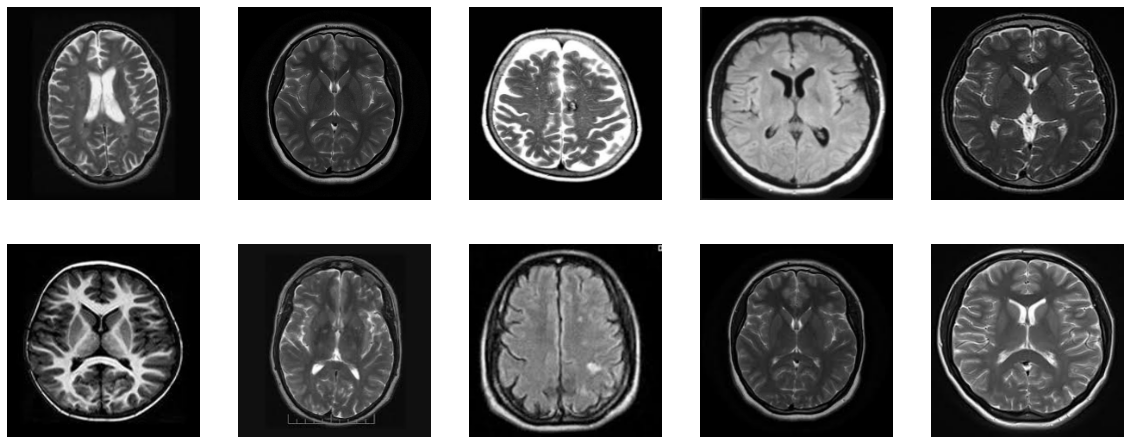

In [11]:
plot_images(0, 97) # 0 to 97 for images with no tumor

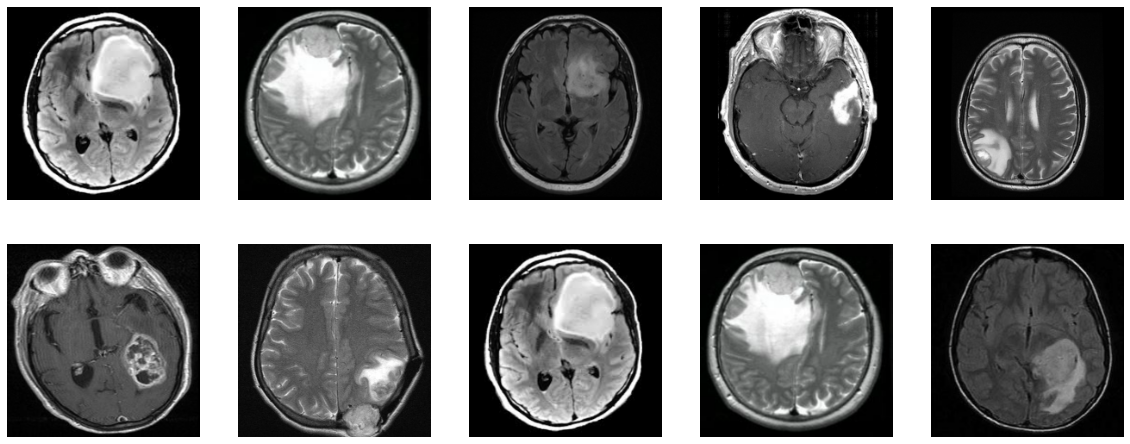

In [12]:
plot_images(98, 252)

 **Data Normalization and Splitting**

In [13]:
from sklearn import preprocessing

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test) 
print("X_train Shape: ", X_train.shape) 
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape) 
print("y_test Shape: ", y_test.shape)

Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)
X_train Shape:  (169, 224, 224, 3)
X_test Shape:  (84, 224, 224, 3)
y_train Shape:  (169, 2)
y_test Shape:  (84, 2)


**Building the model CONV-NET**

In [15]:
from keras.applications import vgg16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Model

In [16]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

In [17]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
CLASS_NAMES = y_train.shape[1]
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
num_hidden = 32
lrate = 0.001
l1 = 0.
l2 = 0.
regularizer = tf.keras.regularizers.l1_l2(l1, l2)

**Model : DenseNet**

In [26]:
# create pre-trained model
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= IMG_SHAPE, pooling= 'max')

model = Sequential([
    base_model,
    tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation='sigmoid',
                            name='dense_hidden'),
    tf.keras.layers.Dense(CLASS_NAMES, 
                            kernel_regularizer=regularizer,
                            activation='sigmoid',
                            name='tumor_prob')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate), loss= 'categorical_crossentropy', metrics= ['accuracy'])

filepath="weights.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 dense_hidden (Dense)        (None, 32)                49184     
                                                                 
 tumor_prob (Dense)          (None, 2)                 66        
                                                                 
Total params: 10,832,785
Trainable params: 10,745,482
Non-trainable params: 87,303
_________________________________________________________________


In [27]:
from tensorflow.keras.models import Model
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
history = model.fit(X_train,y_train,
                    epochs=7, 
                    validation_data=(X_test,y_test), 
                    callbacks=callbacks_list,
                    verbose = 1,
                    initial_epoch=0)

Epoch 1/7
6/6 [==============================] - ETA: 0s - loss: 0.7879 - accuracy: 0.5917
Epoch 1: val_accuracy improved from -inf to 0.59524, saving model to weights.best.h5
6/6 [==============================] - 21s 1s/step - loss: 0.7879 - accuracy: 0.5917 - val_loss: 0.6237 - val_accuracy: 0.5952
Epoch 2/7
6/6 [==============================] - ETA: 0s - loss: 0.3777 - accuracy: 0.8698
Epoch 2: val_accuracy improved from 0.59524 to 0.67857, saving model to weights.best.h5
6/6 [==============================] - 5s 789ms/step - loss: 0.3777 - accuracy: 0.8698 - val_loss: 0.6461 - val_accuracy: 0.6786
Epoch 3/7
6/6 [==============================] - ETA: 0s - loss: 0.2341 - accuracy: 0.9231
Epoch 3: val_accuracy improved from 0.67857 to 0.84524, saving model to weights.best.h5
6/6 [==============================] - 4s 775ms/step - loss: 0.2341 - accuracy: 0.9231 - val_loss: 0.3949 - val_accuracy: 0.8452
Epoch 4/7
6/6 [==============================] - ETA: 0s - loss: 0.1936 - accurac

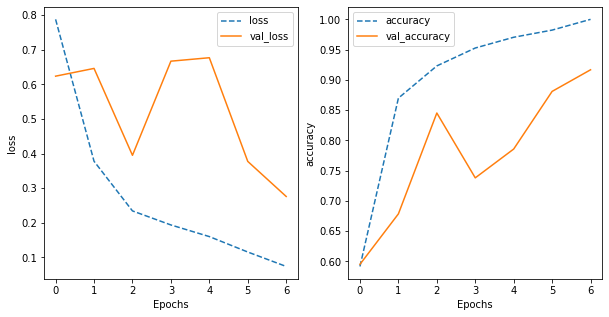

In [28]:
training_plot(['loss', 'accuracy'], history)

In [29]:
Model_1 = load_model("/content/weights.best.h5")

In [30]:
accuracy = Model_1.evaluate(X_test,y_test)
accuracy[1]

3/3 [==============================] - 3s 105ms/step - loss: 0.2759 - accuracy: 0.9167


0.9166666865348816

In [31]:
pred = (Model_1.predict(X_test) > 0.5).astype("int32")

3/3 [==============================] - 2s 130ms/step


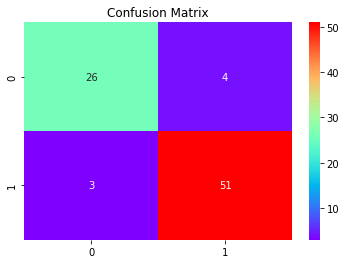

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
sns.heatmap(confusion_matrix(
    y_test.argmax(axis=1), pred.argmax(axis=1)), annot = True, cmap = "rainbow")
plt.title("Confusion Matrix")
plt.show()

In [34]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88        30
           1       0.93      0.94      0.94        54

   micro avg       0.92      0.92      0.92        84
   macro avg       0.91      0.91      0.91        84
weighted avg       0.92      0.92      0.92        84
 samples avg       0.92      0.92      0.92        84

